In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn

# spacy for lemmatization
import spacy

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import nltk

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

D:\Software\Anaconda3\envs\pytorch\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\joblib\backports.py:22: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils  # noqa
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
D:\Software\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprec

In [3]:
df = pd.read_csv('D:\Projects\Jupyter\Github Docs\datasets\preprocessed_word_correct_token.csv', encoding='utf-8')
df.head()

<>:1: DeprecationWarning: invalid escape sequence '\P'
<>:1: DeprecationWarning: invalid escape sequence '\P'
C:\Users\researcher\AppData\Local\Temp\ipykernel_13216\1017671776.py:1: DeprecationWarning: invalid escape sequence '\P'
  df = pd.read_csv('D:\Projects\Jupyter\Github Docs\datasets\preprocessed_word_correct_token.csv', encoding='utf-8')


,id,index,name,content,sentence,review_score,review_votes,readability,preprocessed_reviews,wordtoken,correctmapping,ngrams_reviews,ngrams_token,lda_reviews,lda_token
0,275850,1,No Man's Sky,This was my review prior to the 1.1 update ___...,This was my review prior to the 1.1 update ___...,1,1,17.6,this be my review prior to the update nothis g...,"['this', 'be', 'my', 'review', 'prior', 'to', ...","['this', 'be', 'my', 'review', 'prior', 'to', ...",this be my review prior to the update nothin g...,"['review', 'prior', 'update', 'nothin', 'fail'...",review prior update nothin fail miserably anno...,"['review', 'prior', 'update', 'nothin', 'fail'..."
1,275850,2,No Man's Sky,This was my review prior to the 1.1 update ___...,"When the game first came out it had over 200,0...",1,1,6.5,when the game first come out it have over play...,"['when', 'the', 'game', 'first', 'come', 'out'...","['when', 'the', 'game', 'first', 'come', 'out'...",when the game first come out it have over play...,"['first', 'player', 'one', 'point', 'mear']",first come player one point mear,"['first', 'player', 'one', 'point', 'mear']"
2,275850,3,No Man's Sky,This was my review prior to the 1.1 update ___...,If that doesn't prove this game is the biggest...,1,1,5.6,if that do not prove this game be the big scam...,"['if', 'that', 'do', 'not', 'prove', 'this', '...","['if', 'that', 'do', 'not', 'prove', 'this', '...",if that do not prove this game be the big scam...,"['prove', 'this_game', 'big', 'scam', 'know']",prove big scam know,"['prove', 'big', 'scam', 'know']"
3,275850,4,No Man's Sky,This was my review prior to the 1.1 update ___...,The devs completely lied about countless featu...,1,1,8.7,the developer completely lie about countless f...,"['the', 'developer', 'completely', 'lie', 'abo...","['the', 'developer', 'completely', 'lie', 'abo...",the developer completely lie about countless f...,"['the_developer', 'completely', 'lie_about', '...",developer completely lie countless feature meant,"['developer', 'completely', 'lie', 'countless'..."
4,275850,5,No Man's Sky,This was my review prior to the 1.1 update ___...,______________________________________________...,1,1,29.1,i clearly have very strong feel about the game...,"['clearly', 'have', 'very', 'strong', 'feel', ...","['clearly', 'have', 'very', 'strong', 'feel', ...",clearly have very strong feel about the game a...,"['clearly', 'strong', 'feel', 'play', 'hour', ...",clearly strong feel play hour hello games rele...,"['clearly', 'strong', 'feel', 'play_hour', 'he..."


In [4]:
df=df[:500]

In [5]:
eval(df['lda_token'][4])

['clearly',
 'strong',
 'feel',
 'play_hour',
 'hello_games',
 'release',
 'new',
 'update',
 'decide',
 'need',
 'resist',
 'order',
 'see',
 'sort',
 'improvement']

In [6]:
def convert(s):
    s = eval(s)
    s = ' '.join(s)
    return s
df['lda_token'] = df['lda_token'].apply(convert)

In [7]:
data = df.lda_token.values.tolist()
data[:3]

['review prior update nothin fail miserably annoyed stuck garbage library completely terrible likely never play',
 'first player one point mear',
 'prove big scam know']

# Vectorizer

## TF-IDF vectorizer

In [8]:
tfidf_vectorizer = TfidfVectorizer(
                                 max_df=500, 
                                   max_features=2000,
                                 min_df=0, 
#                                  stop_words='english',
                                   use_idf=True, 
#                                    token_pattern='[a-zA-Z0-9]{3,}', 
#                                    ngram_range=(1,3)
)

%time tfidf_vectorized = tfidf_vectorizer.fit_transform(data)

print(tfidf_vectorized.shape)

CPU times: total: 31.2 ms
Wall time: 11 ms
(500, 1405)


In [9]:
tfidf_data_vectorized = tfidf_vectorizer.fit_transform(data)

In [10]:
tfidf_vectorizer.get_feature_names()

['aaa',
 'abandon',
 'ability',
 'able',
 'absent',
 'absolutely',
 'abstract',
 'accept',
 'achieve',
 'achievement',
 'across',
 'action',
 'active',
 'activism',
 'actually',
 'add',
 'added',
 'addition',
 'additional',
 'address',
 'advance',
 'advanced',
 'advantage',
 'adversity',
 'advertised',
 'advertisement',
 'af',
 'afterward',
 'ago',
 'agree',
 'ahead',
 'ai',
 'aimless',
 'air',
 'algorithm',
 'aliasing',
 'alien',
 'alive',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'alpha',
 'already',
 'also',
 'alternate',
 'although',
 'always',
 'amain',
 'amaze',
 'ambitious',
 'amongst',
 'amount',
 'amp',
 'animal',
 'anisotropic',
 'annoy',
 'annoyed',
 'another',
 'anti',
 'anticipate',
 'anyone',
 'anything',
 'anything_like',
 'anyways',
 'anywhere',
 'apart',
 'apparent',
 'appeal',
 'appreciate',
 'approach',
 'appropriate',
 'argument',
 'armourer',
 'around',
 'arrive',
 'art',
 'artstyle',
 'artsy',
 'aside',
 'ask',
 'aspect',
 'assumption',
 'atlas',
 'atom

In [11]:
tfidf_data_feature_names=tfidf_vectorizer.get_feature_names()

In [12]:
tfidf_data_dense = tfidf_data_vectorized.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("tfidf_Sparsicity: ", ((tfidf_data_dense > 0).sum()/tfidf_data_dense.size)*100, "%")
# Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

tfidf_Sparsicity:  0.586761565836299 %


## Likelihood

In [13]:
Likelyhood_values = []
limit = 75
start = 5
step = 5
for num_topics in range(start, limit, step):
    print(num_topics)
    lda_model = LatentDirichletAllocation(n_components=num_topics,               # Number of topics
                        max_iter=40,               # Max learning iterations
                        learning_method='batch',   
                        random_state=888,          # Random state
                        batch_size=2,            # n docs in each learning iter
                        evaluate_every = 3,       # compute perplexity every n iters, default: Don't
                        perp_tol  = 0.001,
                        n_jobs = -1,               # Use all available CPUs
                        )
    lda_output = lda_model.fit_transform(tfidf_data_vectorized)
    Likelyhood_values.append(lda_model.score(tfidf_data_vectorized))

5
10
15
20
25
30
35
40
45
50
55
60
65
70


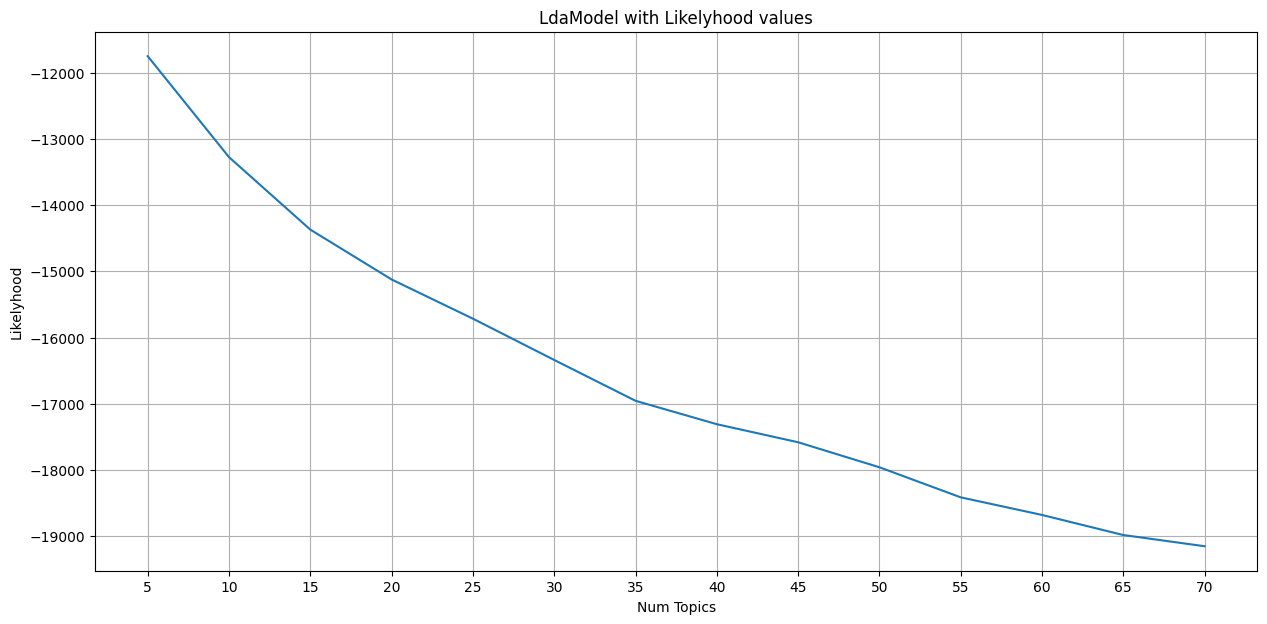

In [15]:
x = range(start, limit, step)
plt.figure(figsize=(15, 7))
plt.plot(x, Likelyhood_values)
plt.xticks(x)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("Likelyhood")
plt.title("LdaModel with Likelyhood values")
plt.savefig("./results/LdaModel with Likelyhood values.png")

In [16]:
Likelyhood_values

[-11748.300070200343,
 -13274.411472467698,
 -14369.15945716534,
 -15122.663544702067,
 -15715.060346532839,
 -16339.069505259544,
 -16956.06056398448,
 -17309.856199406022,
 -17582.619605079002,
 -17960.75882253462,
 -18415.25592720897,
 -18681.293892612262,
 -18984.951007310396,
 -19154.228775345357]

## perplexity

In [18]:
perplexity_values = []
limit = 75
start = 5
step = 5
for num_topics in range(start, limit, step):
    print(num_topics)
    lda_model = LatentDirichletAllocation(n_components=num_topics,               # Number of topics
                                      max_iter=40,               # Max learning iterations
                                      learning_method='batch',   
                                      random_state=888,          # Random state
                                      batch_size=2,            # n docs in each learning iter
                                      evaluate_every = 3,       # compute perplexity every n iters, default: Don't
                                    perp_tol  = 0.001,
                                      n_jobs = -1,               # Use all available CPUs
                                     )
    lda_output = lda_model.fit_transform(tfidf_data_vectorized)
    perplexity_values.append(lda_model.perplexity(tfidf_data_vectorized,sub_sampling=True))

5
10
15
20
25
30
35
40
45
50
55
60
65
70


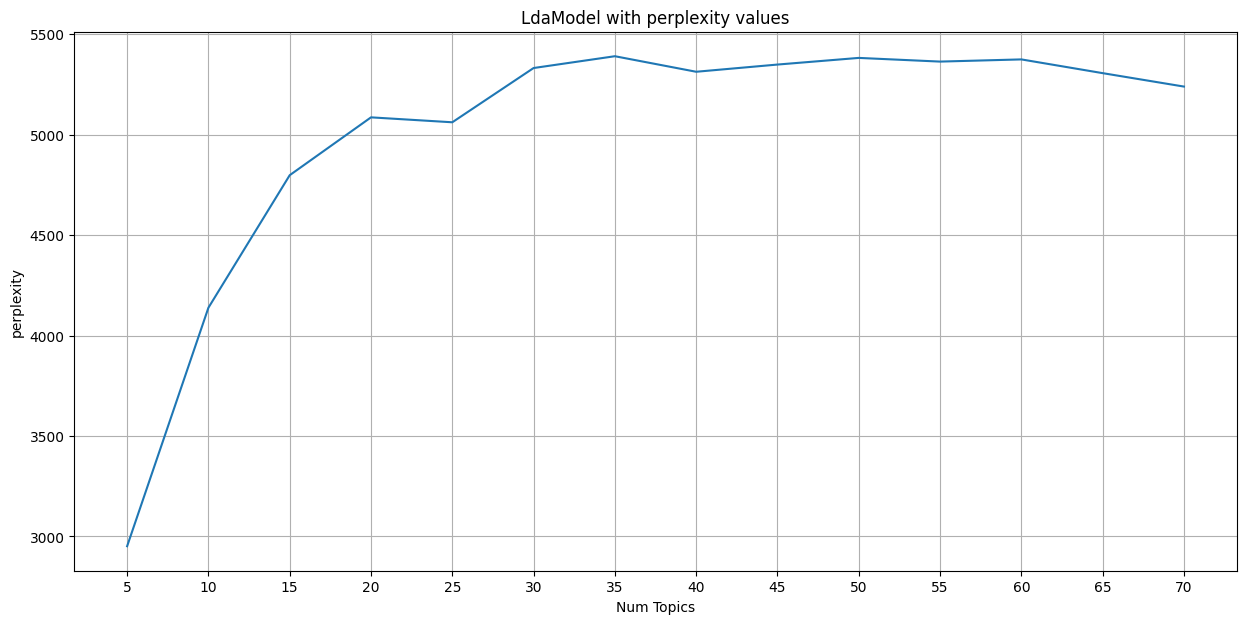

In [19]:
x = range(start, limit, step)
plt.figure(figsize=(15, 7))
plt.plot(x, perplexity_values)
plt.xticks(x)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("perplexity")
plt.title("LdaModel with perplexity values")
plt.savefig("./results/LdaModel with perplexity values.png")

In [20]:
perplexity_values

[2951.2712329803867,
 4138.813923269402,
 4798.609859035419,
 5086.701593716911,
 5062.158484709266,
 5332.289146714875,
 5391.068816918091,
 5313.701934685131,
 5349.557382065452,
 5382.68754664214,
 5364.316660920924,
 5375.219060072688,
 5306.813908446452,
 5239.944888336804]

## coherence 

In [21]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def topic_model_coherence_generator(topic_num_start=2,
                topic_num_end=12,
                step=2,
                norm_corpus='',
                cv_matrix='',
                cv=''):
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    # print(norm_corpus_tokens)
    models = []
    coherence_scores = []

    for i in range(topic_num_start, topic_num_end,step):
        print(i)
        lda_model_best = LatentDirichletAllocation(n_components=5,               # Number of topics
                                           learning_decay=0.9,
                                      max_iter=40,               # Max learning iterations
                                      random_state=888,          # Random state
                                      evaluate_every = 5,       # compute perplexity every n iters, default: Don't
                                    perp_tol  = 0.001,
                                      n_jobs = -1,               # Use all available CPUs
                                     )
        lda_model_best.fit_transform(cv_matrix)
        cur_coherence_score = metric_coherence_gensim(
            measure='c_npmi',
            topic_word_distrib=lda_model_best.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names()),
            texts=norm_corpus_tokens)
        models.append(lda_model_best)
        cur_coherence_score = [i for i in cur_coherence_score if str(i)!='nan']
        # print(cur_coherence_score)
        coherence_scores.append(np.mean(cur_coherence_score))
    return models, coherence_scores

In [22]:
end = 75
start = 5
step = 5
import numpy as np
models, coherence_scores = topic_model_coherence_generator(
    start, end,step, norm_corpus=np.array(data), cv=tfidf_vectorizer, cv_matrix=tfidf_vectorized)

5
10
15
20
25
30
35
40
45
50
55
60
65
70


In [23]:
coherence_scores

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]

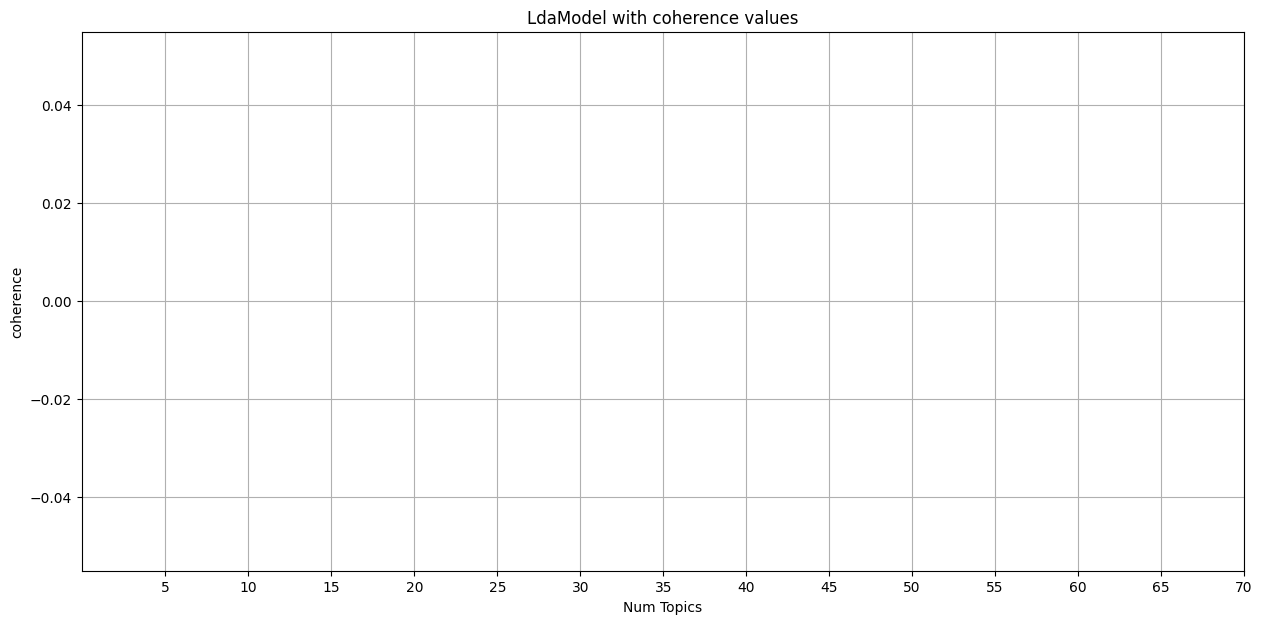

In [24]:
x = range(start, end, step)
plt.figure(figsize=(15, 7))
plt.plot(x, coherence_scores)
plt.xticks(x)
plt.grid()
plt.xlabel("Num Topics")
plt.ylabel("coherence")
plt.title("LdaModel with coherence values")
plt.savefig("./results/LdaModel with coherence values c_npmi.png")